In [1]:
# Basic data management
import pandas as pd
import numpy as np

# Format misc
import pickle

# Make the notebok a bit larger
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Stats 
from scipy.stats import ttest_1samp
import statsmodels.formula.api as smf

# Plot
import seaborn as sns
import pylab as plt
#Colors
palette = ((255/255, 174/255, 143/255), (111/255, 158/255, 206/255))
sns.set(font_scale=1.3)
sns.set_style("white")

%matplotlib inline


# Calculate correlation
from scipy.stats import pearsonr


# Read data

In [2]:
## Uncompress the data
print("Uncompressing processed data (data_clean/all_people_hap) in order")
!unzip -p 'data_clean/all_people_hap_1.zip' > data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_2.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_3.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_4.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_5.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_6.zip' >> data_clean/all_people_hap.csv

Uncompressing processed data (data_clean/all_people_hap) in order


In [3]:
# Read the cleaned data with the ideology of each search
people = pd.read_csv("data_clean/all_people_hap.csv", sep="\t")

# Read the cleaned 
p = pd.read_csv("data_clean/all_people_entropy.csv", sep="\t")

/opt/anaconda/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Plots entropy by constituency

news
AfD


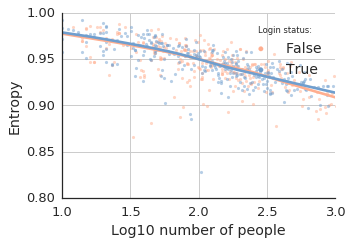

Alexander Gauland


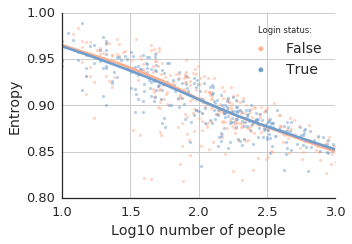

Alice Weidel


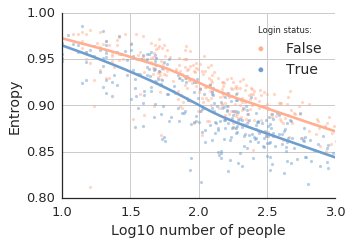

Angela Merkel


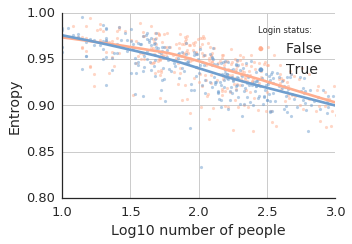

Bündnis90/Die Grünen


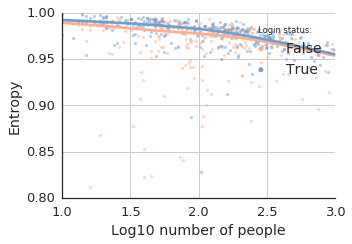

CDU


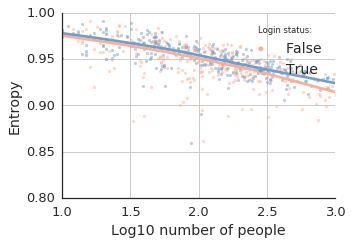

CSU


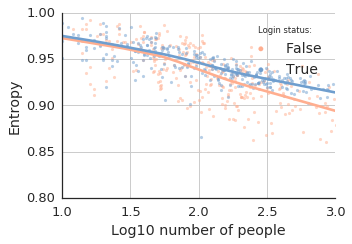

Cem Özdemir


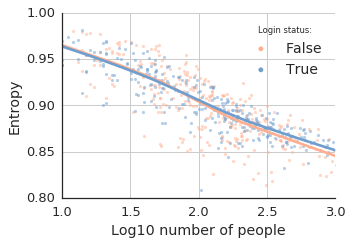

Christian Lindner


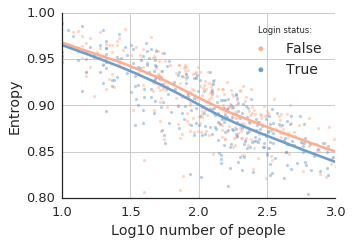

Die Linke


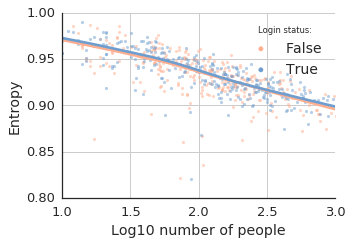

Dietmar Bartsch


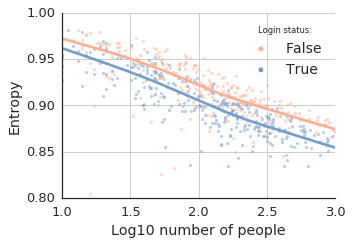

FDP


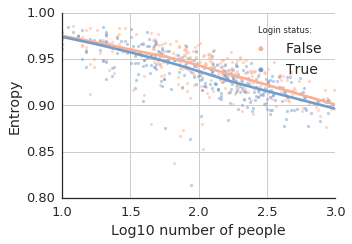

Katrin Göring-Eckardt


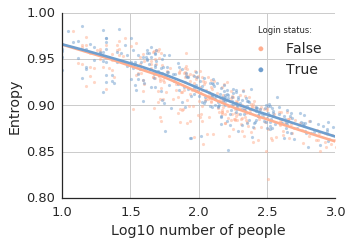

Martin Schulz


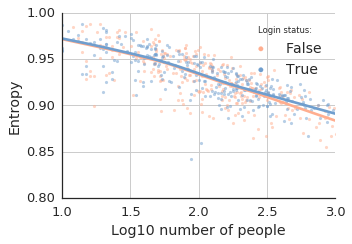

SPD


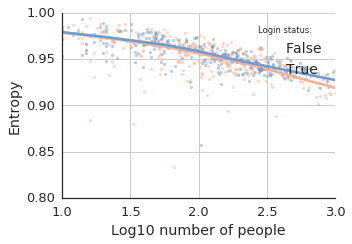

Sahra Wagenknecht


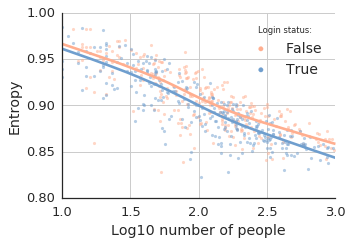

search
AfD


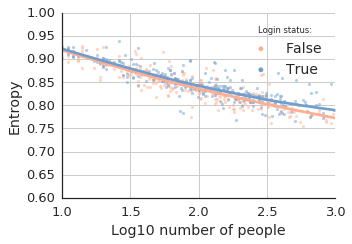

Alexander Gauland


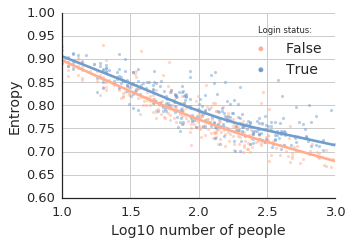

Alice Weidel


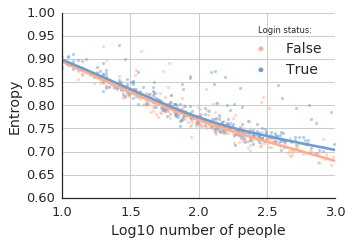

Angela Merkel


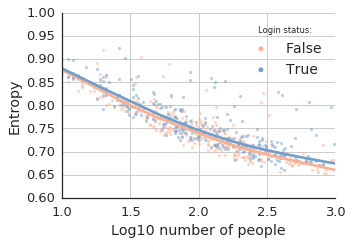

Bündnis90/Die Grünen


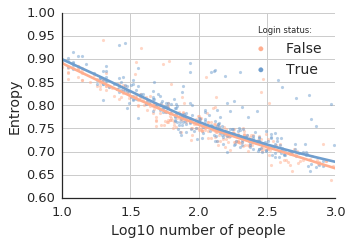

CDU


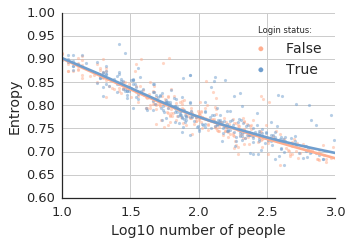

CSU


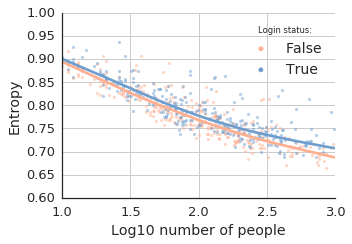

Cem Özdemir


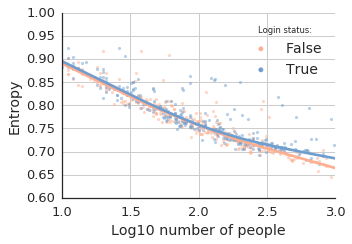

Christian Lindner


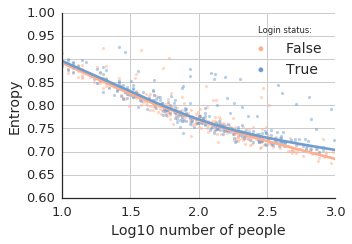

Die Linke


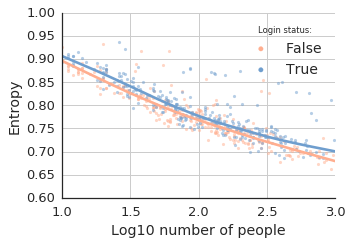

Dietmar Bartsch


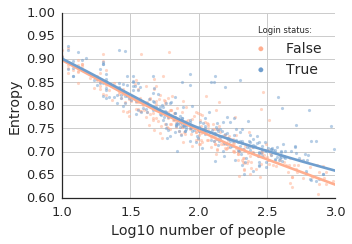

FDP


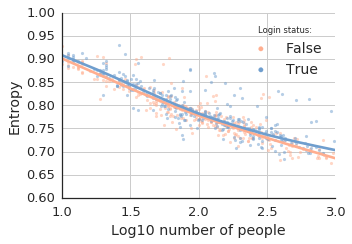

Katrin Göring-Eckardt


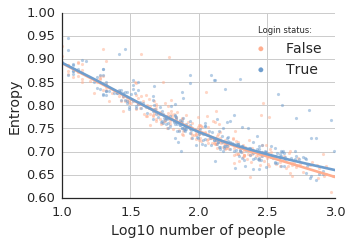

Martin Schulz


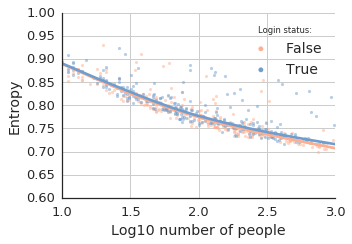

SPD


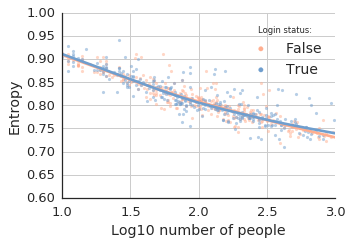

Sahra Wagenknecht


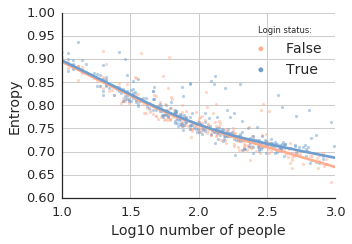

In [4]:
## Plots for each keyword (political party or persons) and search type (google news or search) the entropy per constituency

for a,b in p.groupby("search_type"):
    print(a)
    for d,h in b.groupby(["keyword"]):
        print(d)
        plt.figure(figsize=(5, 3.5))
        for j,h2 in h.groupby("login_status"):
            #Set the color depending on login status
            if not j:
                color=palette[0]
            else:
                color=palette[1]
            #Plot the regression, using lowess fit
            sns.regplot("plugin_id", "result_hash", data=h2, truncate=True,
                        scatter_kws={"s":10, "alpha":0.5}, lowess=True, color=color) #,y_partial="plugin_id")         
            #Plot the scatter plot on top
            plt.scatter([0,0], [0,0], label=str(j), color=color)
           
            
            #Labels
            plt.xlabel("Log10 number of people")
            plt.ylabel("Entropy")
            plt.xlim(1, 3)
        
        # ylimits
        if a == "search":
            plt.ylim(0.6, 1)
        else:
            plt.ylim(0.8, 1)
        
        # Legend and grid
        sns.despine()
        plt.grid()
        legend = plt.legend(title="Login status:", fontsize=14)
        plt.setp(legend.get_title(), fontsize='small')
        plt.tight_layout()

        #save alice
        if d == "Alice Weidel":
            plt.savefig("figures/alice_{}.pdf".format(a))
        plt.show()

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


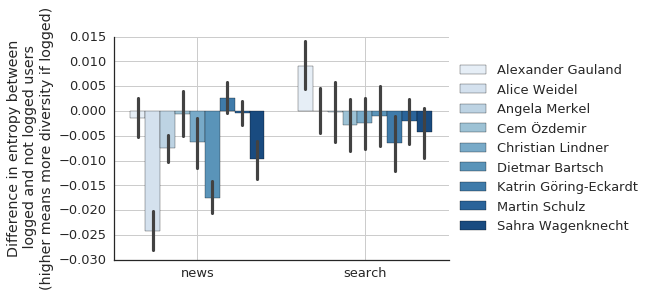

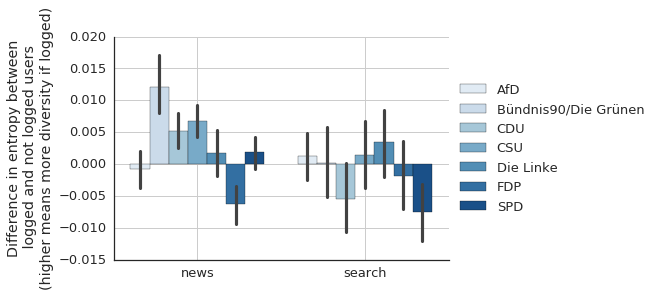

In [5]:
#Plot average difference in entropy. Entropy = diversity by constituency.
diff_p = pd.pivot_table(p,values="result_hash",index=["const_i","keyword","search_type","party"],columns=["login_status"]).reset_index()
for party,diff_p in diff_p.groupby("party"):
    diff_p["diff"] = diff_p[True] - diff_p[False]
    sns.barplot(hue="keyword",y="diff",x="search_type",data=diff_p,palette="Blues")#,palette=["b","b","b","c","r","c","c","r","c","r","r","c","r","r","r","r"])#palette=palette)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    sns.despine()
    plt.xlabel("")
    plt.ylabel("Difference in entropy between\n logged and not logged users\n(higher means more diversity if logged)")
    plt.show()

# Calculates the similarity between political parties, based on the media they share

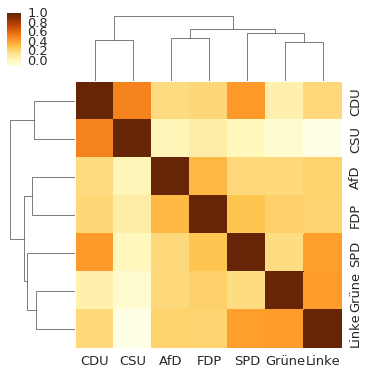

In [6]:
# Define parties
parties = ["AfD", "CDU", "CSU", "FDP", "Grüne", "Linke", "SPD"]

# Change the columns for the visualization
people_cluster = people.copy()
people_cluster.columns = [_.split("_")[-2] if "_ideo" in _ else _ for _ in people_cluster.columns]

# Visualize the correlation matrix, clustered by euclidean distance and average linkage
sns.clustermap(
    people_cluster.loc[people_cluster["search_type"] == "news", ["{}".format(party) for party in parties]].fillna(0).corr(),
    cmap="YlOrBr",figsize=(6,6))

## Political personalization

In [7]:
## Shuffle dataset (to create a null model)
def shuffle(df, n=1, axis=0):     
    df = df.copy().reset_index()
    del df["index"]
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
        return df

In [8]:
# Control by constituency, login_status, keyword and search_type
for party in parties:
    # Calculate the mean by those groups
    people["av_{}_ideo".format(party)] = people.groupby(["login_status","search_type","keyword","const_i"])["{}_ideo".format(party)].transform(np.mean)
    # Remove the mean
    people["diff_{}_ideo".format(party)] = people["{}_ideo".format(party)] - people["av_{}_ideo".format(party)]

In [9]:
## Calculates for each party the average correlation between the ideology of different search queries (for each political party). 
## Also shuffles the dataset to have a null model (if null_flag = True). This is very slow (~1 hour to run)
null_flag = True
    
final1 = []
final1_null = []

#Robust to changes in person (party queries or people query, and to minimum number of articles (count_ideo_all))
for l,data in people.loc[(people["party"]==0)&(people["count_ideo_all"]>1)].groupby(["login_status","search_type"]):
    for party in parties:
        vals = "diff_{}_ideo".format(party)
        
        data1 = data.loc[:,[vals,"const_i","keyword","user"]]
        
        # Pivot data to have each query in a column
        all_keyword = pd.pivot_table(data1,values=vals,columns="keyword",index=["const_i","user"]).replace([0,1],np.NaN)
        persons = list(all_keyword.columns)
        all_keyword = all_keyword.reset_index()
        
        # For each pair of keywords
        corr = []
        corr_null = []
        for k in range(len(persons)):
            for j in range(k+1,len(persons)):
                # Calculate the correaltion
                t = all_keyword[["const_i",persons[k],persons[j]]].dropna()
                c,p = pearsonr(t[persons[k]],t[persons[j]])
                corr.append(c)

                if null_flag:
                    # Use a random model where the search queries are shuffled within the constituency
                    null = pd.concat([shuffle(d) for x,d in t.groupby(["const_i"])])
                    c_null,p = pearsonr(null[persons[k]],null[persons[j]])
                    corr_null.append(c_null)
                else:
                    null = 0
                    c_null,p = 0,0
                    corr_null.append(c_null)                    
        
                # Append the results
                final1.append(list(l)+[party]+corr)
                final1_null.append(list(l)+[party]+corr_null)

        print(party,l,np.mean(corr),np.mean(corr_null))
        

AfD (False, 'news') 0.030316704281369733 0.0
CDU (False, 'news') 0.007373975417683712 0.0
CSU (False, 'news') 0.08714339365192125 0.0
FDP (False, 'news') 0.007345386556791513 0.0
Grüne (False, 'news') 0.18237357062494225 0.0
Linke (False, 'news') 0.06732566550632675 0.0
SPD (False, 'news') 0.21920675772878462 0.0
AfD (False, 'search') 0.004290535043465979 0.0
CDU (False, 'search') 0.06940526268315367 0.0
CSU (False, 'search') 0.029583651595359108 0.0
FDP (False, 'search') 0.07845550434091278 0.0
Grüne (False, 'search') 0.008585547784689875 0.0
Linke (False, 'search') 0.05411662804094962 0.0
SPD (False, 'search') 0.041305629496999424 0.0
AfD (True, 'news') 0.07350030866472573 0.0
CDU (True, 'news') 0.06682101657129719 0.0
CSU (True, 'news') 0.07832922830735184 0.0
FDP (True, 'news') 0.09531679447756536 0.0
Grüne (True, 'news') 0.13972775555527633 0.0
Linke (True, 'news') 0.021689521467258513 0.0
SPD (True, 'news') 0.2838332284220372 0.0
AfD (True, 'search') -0.010621095008684424 0.0
CDU

/opt/anaconda/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


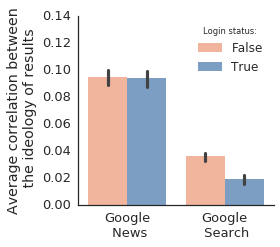

In [10]:
# Plot the results
plt.figure(figsize=(4, 3.5))

plt.subplot(1, 1, 1)
x = pd.DataFrame(final1)
x = pd.melt(x,id_vars=[0, 1, 2])

sns.barplot(x=1, y="value", hue=0, data=x, palette=palette, edgecolor="none")

sns.despine()
plt.xlabel("")
plt.ylabel("Average correlation between\n the ideology of results")
plt.xticks([0., 1.], ["Google\n News", "Google\n Search"])
plt.ylim(-0.0, 0.14)
legend = plt.legend(fontsize=12)
legend.set_title("Login status:", prop = {'size':'small'})

plt.tight_layout()

plt.savefig("figures/corr_ideo.pdf".format(a))
plt.show()



Ttest_1sampResult(statistic=32.33601190569165, pvalue=3.851028262925352e-207)


/opt/anaconda/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


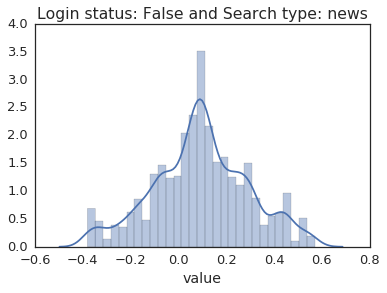

Ttest_1sampResult(statistic=22.545601540367826, pvalue=6.420298048497799e-107)


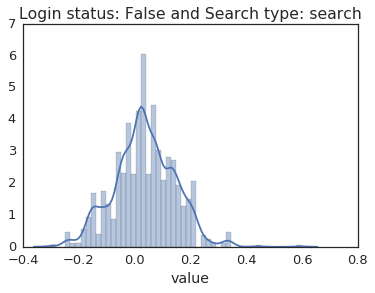

Ttest_1sampResult(statistic=33.17978591330529, pvalue=6.594123400693377e-217)


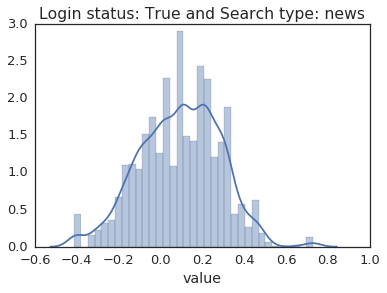

Ttest_1sampResult(statistic=10.824787165166814, pvalue=5.487600510653187e-27)


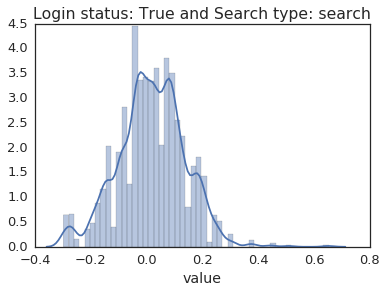

In [11]:
# Plot the distributions and calculate statistics (assumming normal distribution)
for i,data in x.groupby([0,1]):
    plt.title("Login status: {} and Search type: {}".format(*i))
    sns.distplot(data["value"].dropna())
    print(ttest_1samp(data["value"].dropna(),popmean=0))
    plt.show()

/opt/anaconda/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


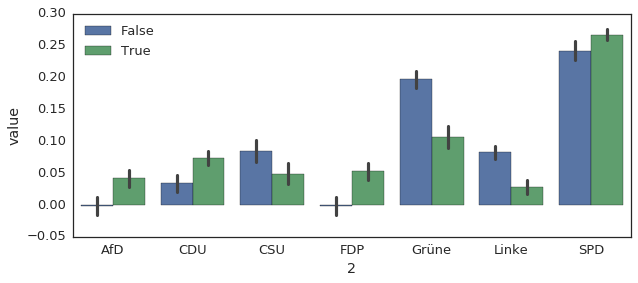

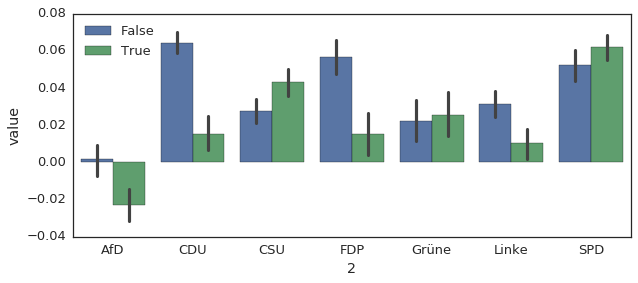

In [12]:
# Plots the result separating by keyword
x = pd.DataFrame(final1)
x = pd.melt(x,id_vars=[0, 1, 2, 3])
plt.figure(figsize=(10, 4))
sns.barplot(x=2, y="value", hue=0, data=x.loc[x[1]=="news"])
plt.figure(figsize=(10, 4))
sns.barplot(x=2, y="value", hue=0, data=x.loc[x[1]=="search"])

# Polarization
Calculate polarization

## DeGroot model. 
[Text from Wikipedia](https://en.wikipedia.org/wiki/DeGroot_learning): 
Take a society of <math> n </math> agents where everybody has an opinion on a subject, represented by a vector of probabilities <math> p(0) = (p_1(0), \dots, p_n(0) ) </math>. Agents obtain no new information based on which they can update their opinions but they communicate with other agents. Links between agents (who knows whom) and the weight they put on each other's opinions is represented by a trust matrix <math> T </math> where <math> T_{ij} </math> is the weight that agent <math> i </math> puts on agent <math> j </math>'s opinion. The trust matrix is thus in a one-to-one relationship with a Weighted graph|weighted, directed graph where there is an edge between <math> i </math> and <math> j </math> if and only if <math> T_{ij} > 0 </math>. The trust matrix is Stochastic matrix|stochastic, its rows consists of nonnegative real numbers, with each row summing to 1.

## Biased assimilation
Based on: Dandekar, P., Goel, A., & Lee, D. T. (2013). Biased assimilation, homophily, and the dynamics of polarization. Proceedings of the National Academy of Sciences of the United States of America, 110(15), 5791–6. http://doi.org/10.1073/pnas.1217220110

The DeGroot model is not polarizing. It always converges to the average opinion of the neighbors (in this case, the neighbors are the media). By assuming that people weights more opinions that are more similar to their own, the model becomes polarizing (for b>1).

## Personalization
We run a simple simulation to show that when s (the opinion of the media) is a function of x(t) (your opinion at time t), the model becomes polarizing for b<1. The specific threshold of b depends on f(s).

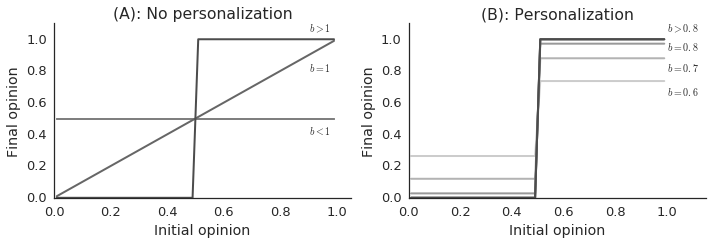

In [13]:
# There are two media, with opinions
media = np.array([0.8, 0.2])
own_op = 1
p = 0.



def update(x, w=None):
    ## Basic model with biased assimilation
    #return (own_op*x+x**b*np.mean(media))/(own_op+x**b*np.mean(media) + (1-x)**b*(1-np.mean(media)))
    
    ## Different relations of s ans x(t)    
#     diffs = np.abs(media-x)
#     f = np.abs(np.diff(diffs))[0]*slope
#     w = np.array([0.5,0.5])
#     w[diffs==np.min(diffs)] += f
#     w[diffs==np.max(diffs)] -= f

    ## The one we used is the following, where s is halfway between the opinion of the media (0.5) and your own opinion
    if w is None:
        w = 1-np.abs(x-media)
        w = w/np.sum(w)
    
    #Linear increase
    return (own_op*x+x**(b+p)*np.sum(media*w))/(own_op+x**(b+p)*np.sum(media*w) + (1-x)**(b+p)*(1-np.sum(media*w)))


## Run models for different parameters, and plot
plt.figure(figsize=(10,3.5))

## Without personalization
plt.subplot(1, 2, 1)
for b in [0.6,0.7,0.8,0.9,1,1.1]:
    x = [0.01,0.1,0.49,0.51,0.9,0.99]
    v = []
    for i in x:
        for j in range(1000):
            i = update(i, w=0.5)
        v.append(i)
    plt.grid()
    plt.plot(x, v, label=str(b)[:4], color=(1.4-b, 1.4-b, 1.4-b), linewidth=2)
    if b == 1:
        plt.annotate(r"$b=1$", (0.9, 0.8))
    if b == 1.1:
        plt.annotate(r"$b>1$", (0.9, 1.05)) 
    if b == 0.6:
        plt.annotate(r"$b<1$", (0.9, 0.4))

sns.despine()
plt.xlabel("Initial opinion")
plt.ylabel("Final opinion")
plt.title("(A): No personalization")
plt.ylim(0,1.1)
plt.xlim(0,1.05)

## With personalization
plt.subplot(1, 2, 2)
for b in [0.6,0.7,0.8,0.9,1,1.1]: 
    x = [0.01,0.1,0.49,0.51,0.9,0.99]
    v = []
    for i in x:
        for j in range(1000):
            i = update(i)
        v.append(i)
    plt.grid()
    plt.plot(x,v,label=str(b)[:3],color=(1.4-b,1.4-b,1.4-b),linewidth=2)

plt.annotate(r"$b=0.6$", (1.,0.65))
plt.annotate(r"$b=0.7$", (1,0.8))
plt.annotate(r"$b=0.8$", (1,0.93))
plt.annotate(r"$b>0.8$", (1,1.05))

sns.despine()
plt.xlabel("Initial opinion")
plt.ylabel("Final opinion")
plt.title("(B): Personalization")
plt.ylim(0,1.1)
plt.xlim(0,1.15)

# Save figure
plt.tight_layout()
plt.savefig("figures/sim_polarization.pdf")
plt.show()
